<a href="https://colab.research.google.com/github/ASEM000/Physics-informed-neural-network-in-JAX/blob/main/%5B1%5D_ODE_PINN_ClassForm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Credits : Mahmoud Asem @Asem000 @CVBML-KAIST  July 2022

In [ ]:
!pip install optax
!pip install serket # for PyTorch like API
!pip install tqdm

In [11]:
#Imports
from __future__ import annotations
from typing import Callable
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import serket as sk 
import optax
import sympy as sp
import functools
from tqdm.notebook import tqdm

### Generate a a differential equation and its solution using SymPy

In [3]:
t= sp.symbols('t')
f = sp.Function('y')
diffeq = sp.Eq(f(t).diff(t,t) + f(t).diff(t)-t*sp.cos(2*sp.pi*t),0)
sol = sp.simplify(sp.dsolve(diffeq,ics={f(0):1,f(t).diff(t).subs(t,0):10}).rhs)

In [ ]:
diffeq

In [ ]:
sp.Eq(f(t).diff(t).subs(t,0),10)

In [ ]:
sp.Eq(f(t).subs(t,0),1)

In [ ]:
sp.Eq(f(t),sol)

In [ ]:
#verify solution
sp.simplify(-t*sp.cos(sp.pi*2*t)+sol.diff(t)+sol.diff(t,t))

### Constructing the MLP

In [ ]:
N_b = 1
N_c = 100

tmin,tmax=0. ,jnp.pi

'''boundary conditions'''


# U[0] = 1
t_0 = jnp.ones([N_b,1],dtype='float32')*0.
ic_0 = jnp.ones_like(t_0) 
IC_0 = jnp.concatenate([t_0,ic_0],axis=1)

# U_t[0] = 10
t_b1 = jnp.zeros([N_b,1])
bc_1 = jnp.ones_like(t_b1) * 10
BC_1 = jnp.concatenate([t_b1,bc_1],axis=1)

conds = [IC_0,BC_1]

#collocation points

key=jax.random.PRNGKey(0)

t_c = jax.random.uniform(key,minval=tmin,maxval=tmax,shape=(N_c,1))
colloc = t_c


# Build Model

In [ ]:
@sk.treeclass
class MLP :
    def __init__(self,key=jax.random.PRNGKey(0)):
        k1,k2,k3,k4 = jax.random.split(key,4)

        self.l1 = sk.nn.Linear(1,20, key=k1)
        self.l2 = sk.nn.Linear(20,20, key=k2)
        self.l3 = sk.nn.Linear(20,20, key=k3)
        self.l4 = sk.nn.Linear(20,1, key=k4)
        
    def __call__(self,x):
        x = self.l1(x)
        x = jax.nn.tanh(x)
        x = self.l2(x)
        x = jax.nn.tanh(x)
        x = self.l3(x)
        x = jax.nn.tanh(x)
        x = self.l4(x)
        return x

model = MLP()
print(model.tree_diagram())
print(model.summary())
print(model.tree_box(array=colloc))


In [15]:
@jax.jit
def MSE(true,pred):
    return jnp.mean((true-pred)**2)

def diff(func:Callable,*args,**kwargs):
  """sum then grad"""
  return jax.grad(lambda *ar,**kws: jnp.sum(func(*ar,**kws)), *args, **kwargs)

def loss_func(model,colloc,conds):
    t_c =colloc[:,[0]]
    ufunc = model
    ufunc_t = diff(model)
        
    loss =jnp.mean(ODE_loss(t_c,ufunc) **2)

    t_ic,u_ic = conds[0][:,[0]],conds[0][:,[1]]  
    loss += MSE(u_ic,ufunc(t_ic))

    t_bc,u_bc = conds[1][:,[0]],conds[1][:,[1]]  
    loss += MSE(u_bc,ufunc_t(t_bc))

    return  loss

def ODE_loss(t,u):
    u_t = diff(u)
    u_tt = diff(u_t)
    return -t*jnp.cos(2*jnp.pi*t) + u_t(t) + u_tt(t)

@jax.jit
def update(opt_state,model,colloc,conds):
    # Get the gradient w.r.t to MLP params
    grads= jax.grad(loss_func)(model,colloc,conds)
    
    #Update model
    updates, opt_state = optimizer.update(grads, opt_state)
    model = optax.apply_updates(model, updates)

    return opt_state,model


In [16]:
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(model)

In [ ]:
%%time
epochs = 10_000
for _ in tqdm(range(1,epochs+1)):
  opt_state,model = update(opt_state,model,colloc,conds)

  # print loss and epoch info
  if _ %(100) ==0:
    print(f'Epoch={_}\tloss={loss_func(model,colloc,conds):.3e}')

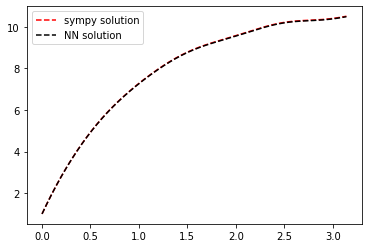

In [19]:
lam_sol= sp.lambdify(t,sol)

dT = 1e-3
Tf = jnp.pi
T = np.arange(0,Tf+dT,dT)


sym_sol =np.array([lam_sol(i) for i in T])

plt.plot(T,sym_sol,'--r',label='sympy solution')
plt.plot(T,model(T.reshape(-1,1))[:,0],'--k',label='NN solution')
plt.legend()